In [11]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import pandas as pd
from src.experiments.common import get_run_from_path
from functools import cache
import tqdm
from src.experiments.common import EXPERIMENT_PATH, Experiment
from omegaconf import OmegaConf

def latest_run_dir(name):
    run_dirs = Experiment(name).run_dirs()
    latest_dir = run_dirs[-1]
    return str(latest_dir.relative_to(EXPERIMENT_PATH))

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np
import seaborn as sns

sns.set_style("white")


In [2]:
name = "cifar"
run_dirs = Experiment(name).run_dirs()
latest_dir = run_dirs[-1]
multi_run = get_run_from_path(EXPERIMENT_PATH / latest_dir)
tag = "err/val"
parameters = ["inference.lr", "inference.initial_rho", "trainer.gradient_clip_val"]

In [3]:
@cache
def get_val_err(run, n=10, tag="err/val"):
    acc = EventAccumulator(str(run.path / "metrics"))
    acc.Reload()
    return sum(x.value for x in acc.Scalars(tag)[-n:]) / n


In [88]:
val_errs = {run.run_index: get_val_err(run) for run in tqdm.tqdm(multi_run.runs)}

def get_params(run):
    return {param: OmegaConf.select(run.config, param) for param in parameters}

param_values = {run.run_index: get_params(run) for run in multi_run.runs}

metrics = (
    pd.DataFrame.from_dict(param_values, orient="index")
    .sort_index()
    .assign(**{tag: pd.Series(val_errs)})
)

100%|██████████| 48/48 [00:00<00:00, 111600.11it/s]


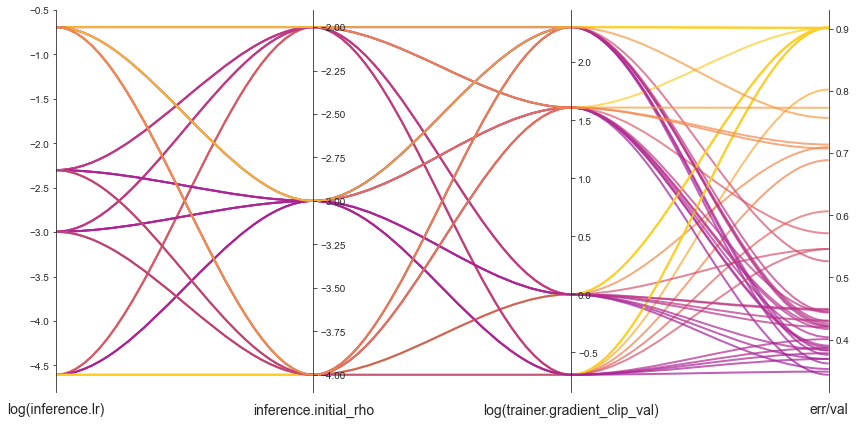

In [91]:
columns = ["inference.lr","inference.initial_rho", "trainer.gradient_clip_val"]
value = "err/val"

plt.figure(figsize=(12, 6))
parallel_coordinates(metrics, columns, value, cmap="plasma")

In [90]:
from scipy.stats import linregress

def guess_log_scale(values):
    y = np.sort(values)
    x = np.arange(len(y))
    _, _, r_norm, _, _  = linregress(x, y)
    if np.all(y > 0):
        _, _, r_log, _, _  = linregress(x, np.log(y))
    else:
        r_log = -np.inf

    return r_norm < r_log

for metric in metrics.columns:
    log_scale = guess_log_scale(metrics[metric].values)
    print(metric, log_scale)

inference.lr True
inference.initial_rho False
trainer.gradient_clip_val True
err/val True


True

In [86]:
def parallel_coordinates(data, columns, value, cmap=None):

    ## Credit: https://stackoverflow.com/a/60401570

    ynames = columns + [value]
    ys = data[ynames].to_numpy()

    for i in range(ys.shape[1]-1):
        if guess_log_scale(ys[:, i]):
            ys[:, i] = np.log(ys[:, i])
            ynames[i] = f"log({ynames[i]})"

    ymins = ys.min(axis=0)
    ymaxs = ys.max(axis=0)
    dys = ymaxs - ymins
    ymins -= dys * 0.05  # add 5% padding below and above
    ymaxs += dys * 0.05
    dys = ymaxs - ymins
    zs = np.zeros_like(ys)
    zs[:, 0] = ys[:, 0]
    zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]


    host = plt.gca()
    # fig, host = plt.subplots(figsize=(10,4))

    axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
    for i, ax in enumerate(axes):
        ax.set_ylim(ymins[i], ymaxs[i])
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        # ax.set_yscale("log")

        if ax != host:
            ax.spines["left"].set_visible(False)
            ax.yaxis.set_ticks_position("right")
            ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

    host.set_xlim(0, ys.shape[1] - 1)
    host.set_xticks(range(ys.shape[1]))
    host.set_xticklabels(ynames, fontsize=14)
    host.tick_params(axis="x", which="major", pad=7)
    host.spines["right"].set_visible(False)

    values = ys[:, -1]
    if cmap is None:
        cmap = plt.get_cmap()
    sm = plt.cm.ScalarMappable(
        cmap=cmap, norm=plt.Normalize(vmin=np.min(values), vmax=np.max(values))
    )
    colors = sm.cmap(values)

    for j in range(ys.shape[0]):

        # create bezier curves
        verts = list(
            zip(
                [
                    x
                    for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)
                ],
                np.repeat(zs[j, :], 3)[1:-1],
            )
        )
        codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
        path = Path(verts, codes)
        patch = patches.PathPatch(
            path, facecolor="none", lw=2, alpha=0.7, edgecolor=colors[j]
        )
        host.add_patch(patch)

    plt.tight_layout()
    plt.show()
